# Prep

In [13]:
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import colorsys

plt.style.use("dark_background")

In [14]:
def hex_to_rgb(hex_code: str):
    hex_code = hex_code.strip("#")

    rgb_values = []
    for i in range(0, 6, 2):
        value = int(hex_code[i : i + 2], 16)
        rgb_values.append(value)

    return tuple(rgb_values)


def scale_lightness(
    rgb: tuple,
    iteration: int,
    scaler: float = 0.95,
):
    h, l, s = colorsys.rgb_to_hls(*rgb)
    r, g, b = colorsys.hls_to_rgb(h, l * scaler**iteration, s)
    return (r / 255, g / 255, b / 255)

In [15]:
# read base file with province ids and geometries
gdf: gpd.GeoDataFrame = gpd.read_file("eu4base.geojson")
gdf.loc[:, "id"] = gdf.id.astype(int)

# read file with all province data
df = pd.read_csv("provinces_data.csv")

# merge data
gdf = gdf.merge(df, on="id", how="left")
gdf = gdf.set_index("id").sort_values("year")
gdf.index = gdf.index.astype(int)

# load player tags and colours
with open("tags_colours.json", "r") as f:
    tags_colours = json.load(f)

In [16]:
tags_colours

{'ENG': '#c11a0e',
 'ARA': '#a64448',
 'HUN': '#98555c',
 'VOL': '#cd2626',
 'WES': '#e7e68a',
 'BAV': '#1174c1'}

In [17]:
years = df.year.unique()
curr_year = max(years)
years = sorted(years, reverse=False)
years

[np.int64(1444), np.int64(1509), np.int64(1562)]

In [18]:
# reformations of tags to include everything
reformations = {
    "ENG": ["ENG"],
    "HUN": ["CRO", "HUN"],
    "ARA": ["ARA"],
    "VOL": ["VOL"],
    "BAV": ["BAV", "UBV"],
    "WES": ["WES", "MUN"],
}

# Plot all players

In [19]:
gdf.superregion.unique()

array(['Eastern Europe', 'East Pacific', 'Central America', None,
       'North America', 'India', 'Western Europe', 'Levant',
       'West Atlantic', 'Tartary', 'North Atlantic', 'East Atlantic',
       'Persia', 'Western Indian Ocean', 'Indian Ocean', 'West Pacific',
       'China', 'Mediterranean Sea', 'Oceania', 'East Indies', 'Andes',
       'Southern Africa', 'Northern Africa', 'Amazonia', 'Far East'],
      dtype=object)

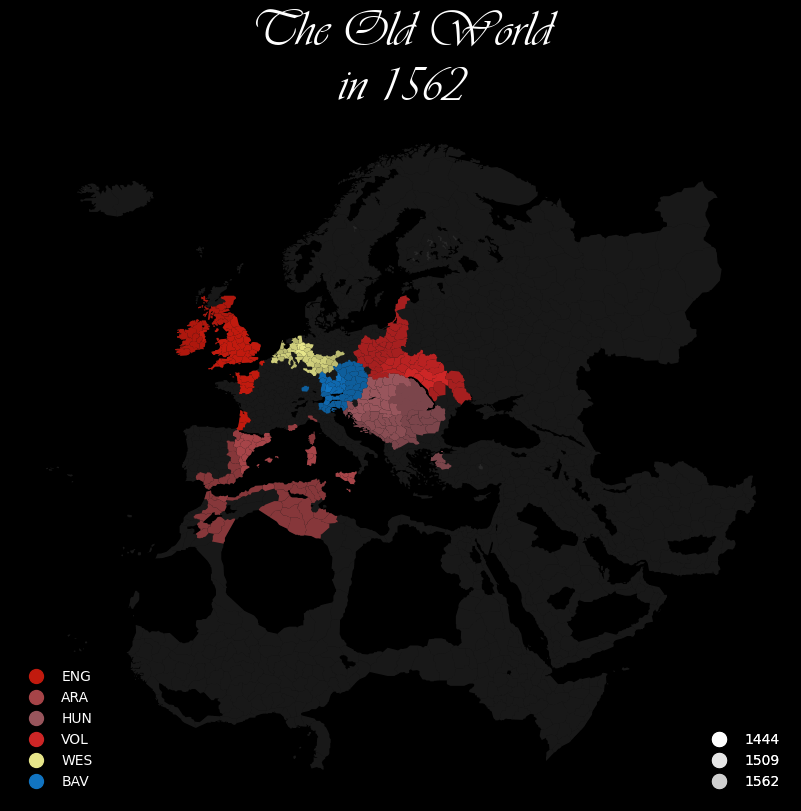

In [25]:
fig, ax = plt.subplots(figsize=(9, 8), layout="constrained")
ax.set_axis_off()

# background
ax = gdf[
    (
        gdf.superregion.isin([
            "Western Europe",
            "Eastern Europe",
            "Mediterranean Sea",
            "Northern Africa",
            "Levant",
            "Mediterranean Sea",
            # "Southern Africa",
            "Persia",
        ])
        # | gdf.region.isin(["Central Asia"])
    )
    & (gdf.terrain == "Land")
].plot(ax=ax, aspect=1, color="#5A5A5A", alpha=0.1)

# ploting tags
for i, year in enumerate(years):
    for tag in tags_colours:
        color = hex_to_rgb(tags_colours[tag])
        cc = [(c * 0.90**i) / 255 for c in color]

        slicer = slice(max(0, i - 1), i + 1)
        tmp = gdf[
            (gdf.tag.isin(reformations[tag]))
            & (gdf.year.isin(years[slicer]))
            & (gdf.continent.isin(["Europe", "Asia", "Africa"]))
            & (gdf.name != "Bermuda")
            & (gdf.name != "Cocos Island")
        ]

        tmp_mx_indx = tmp[tmp.year == year].index
        tmp_mn_indx = tmp[tmp.year != year].index

        province_difference_index = tmp_mx_indx.difference(tmp_mn_indx)

        if province_difference_index.empty:
            if i == 0:
                to_plot = tmp_mx_indx
            else:
                continue
        else:
            to_plot = tmp.loc[province_difference_index]

        gpd.GeoDataFrame(to_plot).plot(
            ax=ax,
            aspect=1,
            facecolor=cc,
        )


# legend - tags
legend_tags = plt.legend(
    handles=[
        Line2D(
            [0],
            [0],
            marker="o",
            linestyle="none",
            markersize=10,
            color=color,
            label=tag,
        )
        for tag, color in tags_colours.items()
    ],
    loc="lower left",
    frameon=False,
)

# legend - years
years_and_gradients = {
    year: gradient
    for year, gradient in zip(
        years,
        [
            (
                1 * 0.9**k,
                1 * 0.9**k,
                1 * 0.9**k,
            )
            for k in range(len(years))
        ],
    )
}

legend_years = plt.legend(
    handles=[
        Line2D(
            [0],
            [0],
            marker="o",
            linestyle="none",
            markersize=10,
            color=color,
            label=year,
        )
        for year, color in years_and_gradients.items()
    ],
    loc="lower right",
    frameon=False,
)

ax.add_artist(legend_tags)
ax.add_artist(legend_years)


plt.title(f"The Old World\nin {curr_year}", fontname="Vivaldi", fontsize=36)
plt.savefig(f"charts/Expansion{curr_year}.png", dpi=1_000, bbox_inches="tight")

# Plot one player

In [21]:
gdf.groupby(["continent", "superregion"])["region"].unique().loc["Asia", "Tartary"]

array(['Tibet', 'West Siberia', 'Central Asia', 'East Siberia',
       'Mongolia'], dtype=object)

In [22]:
gdf[gdf.region == "Scandinavia"]["area"].unique()

array(['North Atlantic Islands', 'Laponia', 'Trøndelag', 'Østlandet',
       'Vestlandet', 'North Jutland', 'Västra Svealand', 'Norrland',
       'Ostrobothnia', 'Västra Götaland', 'Östra Svealand', 'Finland',
       'Denmark', 'Skåneland', 'Östra Götaland'], dtype=object)

KeyError: 'ITA'

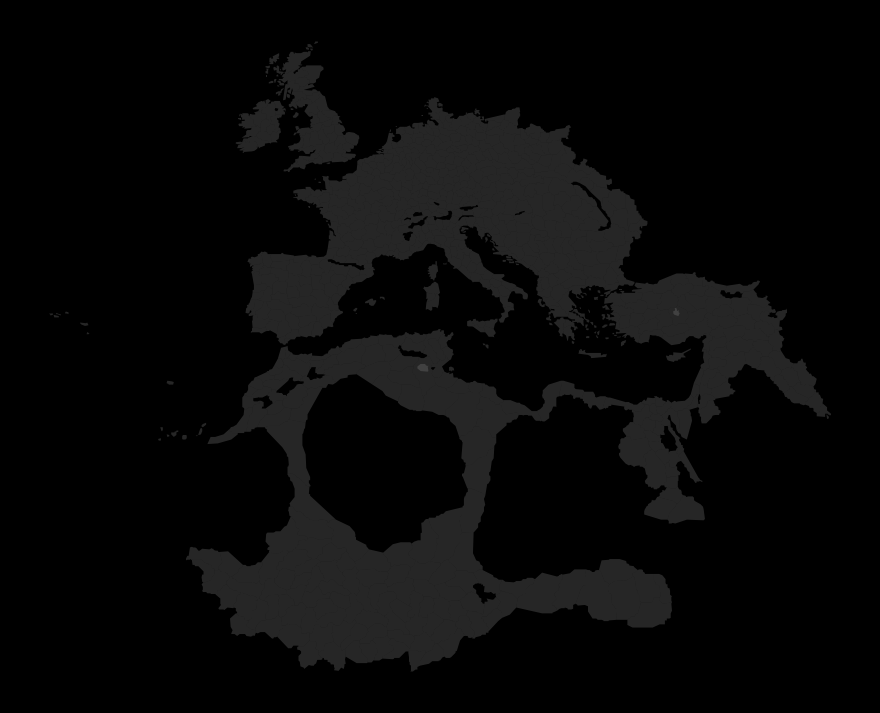

In [23]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_axis_off()
main_tag = "ITA"
title = "Empire of Italy"

# background
ax = gdf[
    (gdf.year == curr_year)
    &
    # (gdf.continent.isin(["Europe"])) |
    # (gdf.superregion.isin(["Levant"])) |
    (
        gdf.region.isin([
            "Britain",
            "Low Countries",
            "North Germany",
            "Iberia",
            "France",
            "South Germany",
            "Italy",
            "Poland",
            "Balkans",
            "Carpathia",
            "Maghreb",
            "Niger",
            "Sahel",
            "Egypt",
            "Mashriq",
            "Anatolia",
        ])
    )
    | (gdf["area"].isin(["Egypt"]))
].plot(ax=ax, aspect=1, color="grey", alpha=0.3)

# plot one tag
year_colours = {}
for i, year in enumerate(years):
    color = hex_to_rgb(tags_colours[main_tag])
    cc = [(c * 0.90**i) / 255 for c in color]
    year_colours[year] = cc

    slicer = slice(max(0, i - 1), i + 1)
    tmp = gdf[
        (gdf.tag.isin(reformations[main_tag]))
        & (gdf.year.isin(years[slicer]))
        & (
            gdf.region.isin([
                "Britain",
                "Low Countries",
                "North Germany",
                "Iberia",
                "France",
                "South Germany",
                "Italy",
                "Poland",
                "Balkans",
                "Carpathia",
                "Maghreb",
                "Niger",
                "Sahel",
                "Egypt",
                "Mashriq",
                "Anatolia",
            ])
        )
    ]

    tmp_mx_indx = tmp[tmp.year == year].index
    tmp_mn_indx = tmp[tmp.year != year].index

    province_difference_index = tmp_mx_indx.difference(tmp_mn_indx)

    if province_difference_index.empty:
        if i == 0:
            to_plot = tmp_mx_indx
        else:
            continue
    else:
        to_plot = tmp.loc[province_difference_index]

    gpd.GeoDataFrame(to_plot).plot(ax=ax, aspect=1, facecolor=cc)


# legend - years
leg_points = ax.legend(
    [
        Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color)
        for color in year_colours.values()
    ],
    year_colours.keys(),
    ncol=1,
    frameon=False,
    loc="lower right",
)
ax.add_artist(leg_points)


plt.title(f"{title}\nin {curr_year}", fontname="Vivaldi", fontsize=36)
plt.savefig(f"charts/{main_tag}_{curr_year}.png", dpi=500, bbox_inches="tight")

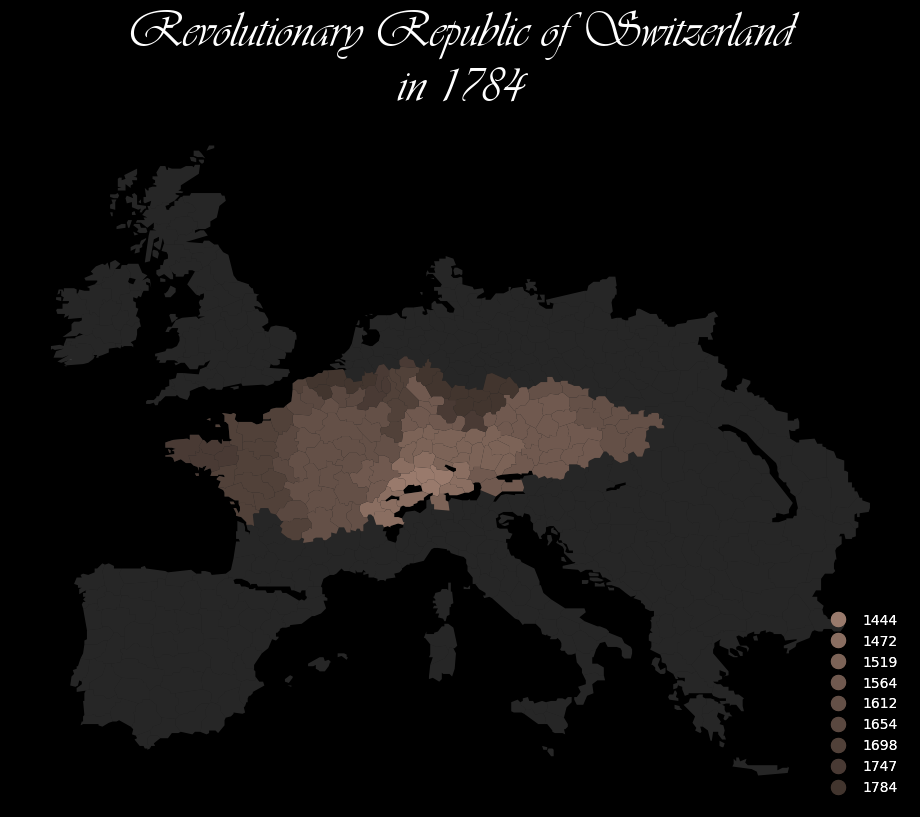

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_axis_off()
main_tag = "SWI"
title = "Revolutionary Republic of Switzerland"

# background
ax = gdf[
    (gdf.year == curr_year)
    &
    # (gdf.continent.isin(["Europe"])) |
    # (gdf.superregion.isin(["Levant"])) |
    (
        gdf.region.isin([
            "Britain",
            "Low Countries",
            "North Germany",
            "Iberia",
            "France",
            "South Germany",
            "Italy",
            "Poland",
            "Balkans",
            "Carpathia",
        ])
    )
].plot(ax=ax, aspect=1, color="grey", alpha=0.3)

# plot one tag
year_colours = {}
for i, year in enumerate(years):
    color = hex_to_rgb(tags_colours[main_tag])
    cc = [(c * 0.90**i) / 255 for c in color]
    year_colours[year] = cc

    slicer = slice(max(0, i - 1), i + 1)
    tmp = gdf[
        (gdf.tag.isin(reformations[main_tag]))
        & (gdf.year.isin(years[slicer]))
        & (gdf.name != "Bermuda")
    ]

    tmp_mx_indx = tmp[tmp.year == year].index
    tmp_mn_indx = tmp[tmp.year != year].index

    province_difference_index = tmp_mx_indx.difference(tmp_mn_indx)

    if province_difference_index.empty:
        if i == 0:
            to_plot = tmp_mx_indx
        else:
            continue
    else:
        to_plot = tmp.loc[province_difference_index]

    gpd.GeoDataFrame(to_plot).plot(ax=ax, aspect=1, facecolor=cc)


# legend - years
leg_points = ax.legend(
    [
        Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color)
        for color in year_colours.values()
    ],
    year_colours.keys(),
    ncol=1,
    frameon=False,
    loc="lower right",
)
ax.add_artist(leg_points)


plt.title(f"{title}\nin {curr_year}", fontname="Vivaldi", fontsize=36)
plt.savefig(f"charts/{main_tag}_{curr_year}.png", dpi=500, bbox_inches="tight")

# ...